# 0. Information

Author: Connor Lismore

About: A 'Hello World' sample of the data augmentation process for the robocup
        Compared to the full pipeline, the following only takes images and labels from the '96' folder, and             does the augmentation, tfrecord generation and model training and evaluation for said            folder.

# 1. Packages and Other Includes
Before we can start preparing our data for augmentation and object detection training, we require a selection of Packages that will allow us to commence with Data Preprocessing, Augmentation, and other preperations in order to begin with Object Detection Training.

In [1]:
# Imported Modules
import os                           #For File Pathing
#import pandas as pd                 #For Data Analysis and Manipulation
#import matplotlib.pyplot as plt     #For Data Graphing
import numpy as np                  #For Data Manipulation
import tensorflow as tf             #For Object Detection
import albumentations as A          #For Data Augmentation
import random 

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Check tensorflow version and if the current work machine has a cuda capable gpu
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

# Custom Modules from the R2 team
import util.visual as vis           #For Data Visualization
import util.utils as util           #Miscallenaous Utilities
import util.model as md             #For Models
import util.dataset as ds           #For Dataset Preprocessing

from functools import partial

2.5.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/c/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# 2. Pathing and Definitions

In order to make work easier, it is best to lay down some path definitions, in order to point the locations of the various data we use, such as the images and the label files

In [2]:
# Define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
base_path = '../../ObjectDetection'
dataset_path = os.path.sep.join([base_path, 'data/datasets'])
img_path = os.path.sep.join([dataset_path, 'raw/ImageTagger'])
labels_path = os.path.sep.join([dataset_path, 'ImageTagger/labels'])
labels_aug_path = os.path.sep.join([dataset_path, 'ImageTagger/labels_aug'])
records_path = os.path.sep.join([dataset_path, 'ImageTagger/records'])

#img_sample_aug_path = os.path.sep.join([img_path, '96-aug'])
#label_sample_cleaned_path = os.path.sep.join([labels_path, '96'])
#label_sample_aug_path = os.path.sep.join([labels_aug_path, '96_aug.csv'])

params = util.get_params(os.path.sep.join([base_path, 'params.yaml']))
info_path = os.path.sep.join([dataset_path, 'ImageTagger/info.json'])

train_record_path = os.path.sep.join([records_path, 'train'])
test_record_path = os.path.sep.join([records_path, 'test'])

models_path = '../../Config/NeuralNets/PlayersDeeptector/multi_object_test_final_aug'
#model_name = 'multi_object_test'
logs_path = os.path.sep.join([base_path, 'data/logs/'])
chkpts_path = os.path.sep.join([base_path, 'data/checkpoints/'])
history_path = os.path.sep.join([base_path, 'data/history/multi_object_test_aug.csv'])
graphs_path = os.path.sep.join([base_path, 'data/graphs/'])
tables_path = os.path.sep.join([base_path, 'data/tables/'])

# 3. TFRecord Generation

Once dataset processing has been completed, it is time to convert the image and label data into a corresponding Tensorflow Record (TFRecord) file. The following is a list of reasons on why TFRecord Files are utilized:
* What is a TFRecord? : a format for storing sequences of binary records for use in Tensorflow
* It is more efficent when it comes to data reading 
* It is optimized for Tensorflow model training

In [3]:
# !python3 generate_tfrecord.py \
#     --csv_dir={labels_path} \
#     --images_dir={img_path} \
#     --images_subdir= \
#     --output_dir={records_path} \
#     --info_path={info_path}

# 4.2 Data Augmentation - Function

In [4]:
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

transforms = A.Compose([
            A.MotionBlur(blur_limit = (3,7), p = 0.5), #Blur Image to random levels
            A.RandomBrightnessContrast(brightness_limit = 0.5, contrast_limit = 0.5, p = 0.5), #Random adjustments in brightness and contrast
            A.GaussNoise(var_limit = (10.0, 50.0), mean = 0, p = 0.5),
            A.RGBShift(r_shift_limit = 20, g_shift_limit = 20, b_shift_limit = 20, p = 0.5)
            #A.HorizontalFlip(p = 0.5)
        ])#, bbox_params=bbox_params)

In [5]:
def image_aug_fn(image, label, img_size):              
    aug_data = util.augment(image = image, bboxes = image)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[120, 160])

    return aug_img

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=image_aug_fn, inp=[image, label, img_size], Tout=tf.uint8)

    return aug_img, label

def set_shapes(img, label, img_shape=(None,None,1)):
    img.set_shape(img_shape)
    label.set_shape([None, 5])
    print(img)
    print(label)
    return img, label

def get_augmented_dataset(path, batch_size, grid_shape, shuffle=True):
    dset = ds.load_tfrecord_dataset(path)

    dset_aug = dset.map(partial(process_data, img_size = 160),num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    dset_aug = dset_aug.map(set_shapes, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    dset_opt = dset.map(lambda x,y: (x, util.preprocess_true_boxes(y, grid_shape)))

    if shuffle:
        dset_opt = dset_opt.shuffle(buffer_size = 512)
    
    dset_opt = dset_opt.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dset_opt

In [6]:
# def visualize_augmented_dataset_sample(path, batch_size, grid_shape, shuffle = True):
#     dset = ds.load_tfrecord_dataset(path)
#     print(dset)

#     dset_aug = dset.map(partial(process_data, img_size = 160), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
#     dset_aug = dset_aug.map(set_shapes, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

#     dset_opt = dset_aug.map(lambda x,y: (x, util.preprocess_true_boxes(y, grid_shape))).batch(1).skip(0).take(10)

#     if shuffle:
#         dset_opt = dset_opt.shuffle(buffer_size = 512)

#     #dset_opt = dset_opt.batch(batch_size, drop_remainder= True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#     for img, lbl in dset_opt:
#         vis.visualize_output_tensor(lbl, lbl, tf.squeeze(img), params.dataset.image.size, params.model.grid.shape, conf_threshold=0.3)

# 5. Model Preperation

At this stage, our data is ready to be utilized in model training. However, we now need to prepare our model.

In [7]:
# import tensorflow_addons as tfa

# def loss(y_true, y_pred):
#         xy_pred, wh_pred, conf_pred, classes_pred = md.decode_output(y_pred)

#         classes_true = y_true[..., 5:]
#         conf_true = y_true[..., 4]
#         xy_true = y_true[..., 0:2]
#         wh_true = y_true[..., 2:4]

#         obj_mask = tf.zeros(tf.shape(y_true)[:4])
#         obj_mask = tf.expand_dims(conf_true, axis=-1)

#         xy_loss = tf.reduce_sum(tf.square(xy_true - xy_pred) * obj_mask) / 2.0
#         wh_loss = tf.reduce_sum(tf.square(tf.sqrt(wh_true) - tf.sqrt(wh_pred)) * obj_mask) / 2.0

#         #tf.nn.softmax_cross_entropy_with_logits und sigmoid rausnehmen
#         #cross_entr = losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE) # From logits?
#         #class_loss = tf.nn.softmax_cross_entropy_with_logits(labels=classes_true, logits=classes_pred)
#         #class_loss = tf.reduce_sum(class_loss * tf.squeeze(obj_mask))

#         #bceFunc = losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
#         #conf_loss = bceFunc(conf_true, conf_pred)
#         #conf_loss = tf.reduce_sum(tf.square(conf_true - conf_pred)) 
#         fl = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.NONE)

#         conf_loss = fl(conf_true, conf_pred)
#         conf_loss_sum = tf.reduce_sum(conf_loss)

#         class_loss = fl(classes_true, classes_pred)
#         class_loss_sum = tf.reduce_sum(class_loss * tf.squeeze(obj_mask))

#         #return (xy_loss + wh_loss + conf_loss + class_loss) / y_true.shape[0]
#         return (xy_loss*5 + wh_loss*5 + conf_loss_sum + class_loss_sum) / (y_true.shape[0] + 5 + 5)

# # model = tf.keras.models.load_model('/home/c/hskl-robocupgermanopen-2021/ObjectDetection/data/models/experimodel/experimodel.hdf5', custom_objects={'loss': loss})
# model_params = util.get_params()
# model = md.MultiNaoModel((model_params.dataset.image.size[1], model_params.dataset.image.size[0]), model_params.model.layers)

# model.compile(loss = loss)

# model.summary()

# 6. Model Training

We have prepared our dataset, and have now also prepared our model. Now comes the hour to train our model.

In [8]:
tfrecord_dir_train = '/home/c/hskl-robocupgermanopen-2021/ObjectDetection/data/datasets/ImageTagger/records/train'
tfrecord_dir_test = '/home/c/hskl-robocupgermanopen-2021/ObjectDetection/data/datasets/ImageTagger/records/test'
#tfrecord_paths = [os.path.join(FLAGS.tfrecord_dir, f) for f in os.listdir(FLAGS.tfrecord_dir)]
tfrecord_paths_train = [os.path.join(tfrecord_dir_train, f) for f in os.listdir(tfrecord_dir_train)]
tfrecord_paths_test = [os.path.join(tfrecord_dir_test, f) for f in os.listdir(tfrecord_dir_test)]

#trainset = ds.get_optimised_dataset(tfrecord_paths_train, 10, (10, 8))
trainset = ds.get_augmented_dataset(tfrecord_paths_train, 10, (10, 8))
valset = ds.get_optimised_dataset(tfrecord_paths_test, 10, (10, 8))

# test trainset to see everything is good
# visualize_augmented_dataset_sample(tfrecord_paths_train, 10, (10, 8))

Tensor("args_0:0", shape=(None, None, 1), dtype=uint8)
Tensor("args_1:0", shape=(None, 5), dtype=float32)


In [9]:

# from tensorflow.keras.callbacks import (
#     ReduceLROnPlateau,
#     EarlyStopping,
#     ModelCheckpoint,
#     TensorBoard
# )

# callbacks = [   ReduceLROnPlateau(verbose=1, patience = 5),
#                 EarlyStopping(patience = 10, verbose=1, restore_best_weights=True, monitor='val_loss'), # Im Moment: Loss von bbox betrachten, später val_loss
#                 ModelCheckpoint(chkpts_path + model_name + '_{epoch}.tf', verbose=1, save_weights_only=True),
#                 TensorBoard(log_dir=logs_path + '{}'.format(time()))
#                 ]

# model.fit(
#     #trainset,
#     get_augmented_dataset(tfrecord_paths_train, 10, (10, 8)),
#     validation_data=valset,
#     epochs=200,
#     callbacks=[callbacks]
# )

In [10]:
!python3 train.py \
	--tfrecord_dir={tfrecord_dir_train} \
	--tfrecord_test_dir={tfrecord_dir_test} \
	--output_dir={models_path} \
	--chkpts_dir={chkpts_path} \
	--logs_dir={logs_path} \
	--history_path={history_path} \
	--dataset_info_path={info_path} \
	--augment_data=True

2021-07-07 17:40:06.839570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
/home/c/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2021-07-07 17:40:09.102440: I tensorflow/stre

In [11]:
# model.save(models_path + model_name)
# model.save(models_path + model_name + '.hdf5', save_format = 'h5')

In [12]:
model = tf.keras.models.load_model(os.path.sep.join([models_path, 'multi_object_test_noaug.hdf5']), custom_objects={'loss': md.multi_nao_loss})
#model.summary()

OSError: SavedModel file does not exist at: ../../Config/NeuralNets/PlayersDeeptector/multi_object_test_final_aug/multi_object_test_noaug.hdf5/{saved_model.pbtxt|saved_model.pb}

# 10. Model Evaluation

The model has been trained. However, we need to make sure that it is also capable of doing what we want it to do. For that, we need to run some evaluations.

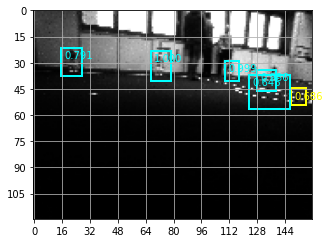

In [ ]:
random_image = random.choice(os.listdir(img_path + '/97/'))

image = tf.keras.preprocessing.image.load_img(os.path.sep.join([img_path + '/97/', random_image]), color_mode="grayscale", target_size=(params.dataset.image.size[1], params.dataset.image.size[0]))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
pred = model.predict(input_arr)

bbox_list_corners = util.postprocess_model_output(pred, params.dataset.image.size, conf_threshold=0.3)

ax = vis.plot_image_with_grid(image, params.dataset.image.size, params.model.grid.shape)
vis.plot_bbox_list(ax, pred_bbox_list=bbox_list_corners)

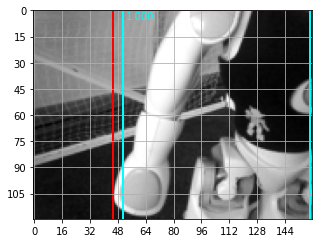

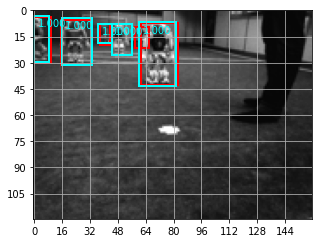

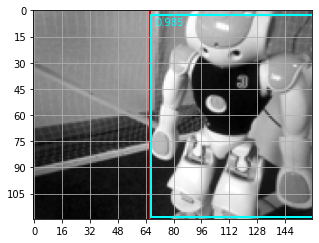

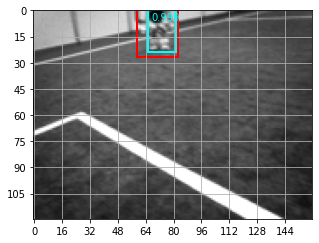

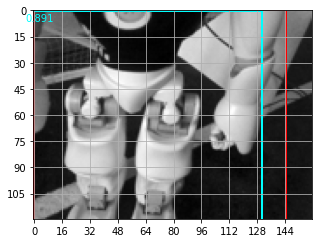

In [ ]:
testset = ds.load_tfrecord_dataset('/home/c/hskl-robocupgermanopen-2021/ObjectDetection/data/datasets/ImageTagger/records/test/test_0.record').map(lambda x,y: (x, util.preprocess_true_boxes(y, params.model.grid.shape))).batch(1).skip(10).take(5)

true_bboxes_list = []
pred_bboxes_list = []
for id, (img, lbl) in enumerate(testset):
    pred = model.predict([img])

    true_bboxes = util.postprocess_dataset_labels(lbl, params.dataset.image.size)
    #print(true_bboxes)
    pred_bboxes = util.postprocess_model_output(pred, params.dataset.image.size, 0.6)
    ax = vis.plot_image_with_grid(tf.squeeze(img), params.dataset.image.size, params.model.grid.shape)
    vis.plot_bbox_list(ax, true_bbox_list=true_bboxes, pred_bbox_list=pred_bboxes)
    #vis.plot_bbox_list(ax, true_bbox_list=true_bboxes)

* Red Boxes: Original Bounding Boxes belonging to the validation set
* Blue Boxes: Predicted Locations of possible objects